# [機械学習/深層学習] 畳み込みニューラルネットワークを実装してMNISTの分類


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),          # [0,255] → [0,1]
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 450kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.8MB/s]


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))   # (B, 32, 28, 28)
        x = self.pool(x)                # (B, 32, 14, 14)
        x = torch.relu(self.conv2(x))   # (B, 64, 14, 14)
        x = self.pool(x)                # (B, 64, 7, 7)
        x = x.view(x.size(0), -1)       # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

③ 学習ループ（MLPと対応）

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
for epoch in range(10):
    model.train()
    for x, t in train_loader:
        x, t = x.to(device), t.to(device)

        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, t)
        loss.backward()
        optimizer.step()

    # 検証
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, t in test_loader:
            x, t = x.to(device), t.to(device)
            y = model(x)
            pred = y.argmax(dim=1)
            correct += (pred == t).sum().item()
            total += t.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Test Accuracy = {acc:.4f}")


Epoch 1: Test Accuracy = 0.9792
Epoch 2: Test Accuracy = 0.9840
Epoch 3: Test Accuracy = 0.9883
Epoch 4: Test Accuracy = 0.9894
Epoch 5: Test Accuracy = 0.9898
Epoch 6: Test Accuracy = 0.9903
Epoch 7: Test Accuracy = 0.9914
Epoch 8: Test Accuracy = 0.9853
Epoch 9: Test Accuracy = 0.9888
Epoch 10: Test Accuracy = 0.9909


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def collect_correct_incorrect(model, dataloader, device, max_samples=20):
    model.eval()

    correct = []
    incorrect = []

    with torch.no_grad():
        for x, t in dataloader:
            x, t = x.to(device), t.to(device)
            y = model(x)
            pred = y.argmax(dim=1)

            for i in range(x.size(0)):
                img = x[i].cpu().squeeze().numpy()
                true = t[i].item()
                p = pred[i].item()

                if true == p and len(correct) < max_samples:
                    correct.append((img, true, p))
                elif true != p and len(incorrect) < max_samples:
                    incorrect.append((img, true, p))

                if len(correct) >= max_samples and len(incorrect) >= max_samples:
                    return correct, incorrect

    return correct, incorrect


In [7]:
def show_correct_incorrect(correct, incorrect, n=10):
    fig = plt.figure(figsize=(12, 4))

    # 正解例
    for i, (img, t, p) in enumerate(correct[:n]):
        ax = fig.add_subplot(2, n, i + 1)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"✓ T:{t} P:{p}", fontsize=9)
        ax.axis("off")

    # 不正解例
    for i, (img, t, p) in enumerate(incorrect[:n]):
        ax = fig.add_subplot(2, n, n + i + 1)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"✗ T:{t} P:{p}", fontsize=9)
        ax.axis("off")

    plt.suptitle("MNIST CNN Classification Results")
    plt.tight_layout()
    plt.show()


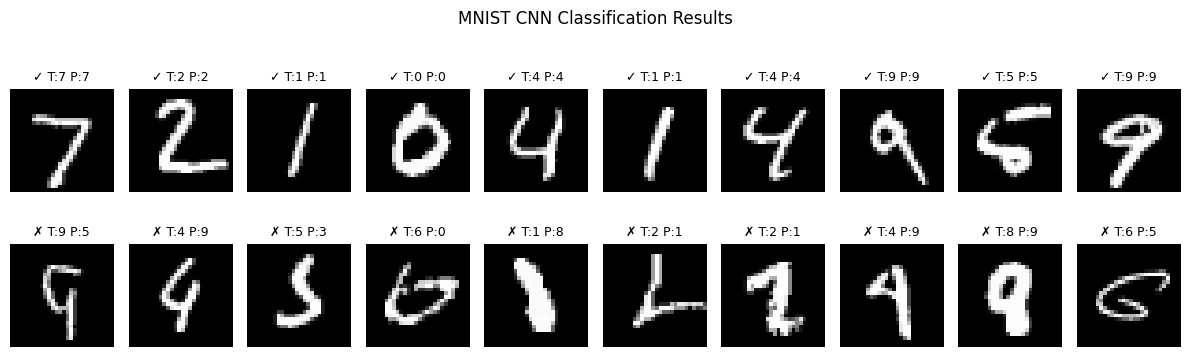

In [8]:
correct, incorrect = collect_correct_incorrect(
    model,
    test_loader,
    device,
    max_samples=20
)

show_correct_incorrect(correct, incorrect, n=10)
